## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

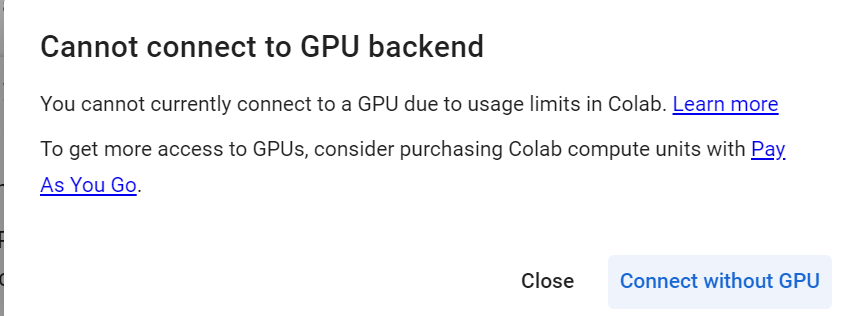

## **Installing and Importing Necessary Libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [ ]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# to compute distances
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score

# importing the PyTorch Deep Learning library
import torch

# to import the model
from sentence_transformers import SentenceTransformer

# to cluster the data
from sklearn.cluster import KMeans

# to compute metrics
from sklearn.metrics import classification_report

# to avoid displaying unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## **Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
news = pd.read_csv('/content/drive/MyDrive/AIML_Program/NLP/stock_news.csv')

In [ ]:
data = news.copy()

## **Data Overview**

### Checking the first five rows of the data

In [ ]:
# print first 5 rows of the dataset
data.head()

### Checking the last five rows of the data

In [ ]:
data.tail()

### Checking the shape of the data

In [ ]:
data.shape

* There are 349 rows and 8 columns.

### Checking for missing values

In [ ]:
data.isnull().sum()

* There are no missing values.

### Checking for duplicate values

In [ ]:
data.duplicated().sum()

* There are no duplicate values.

### Checking the data types of the columns in the dataset

In [ ]:
data.info()

### Statistical summary of the numerical columns

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data.info()

In [ ]:
data.describe().T

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Observation on Label

In [ ]:
labeled_barplot(data, "Label")

* There are 99 Negative, 170 Neutral, and 80 Positive labels.
* The data is imbalanced.

### Add a column to show the change in stock price

In [ ]:
data['Price_Change'] = data['Close'] - data['Open']

In [ ]:
data.head()

In [ ]:
num_unique_dates = data['Date'].nunique()
print("Number of unique dates:", num_unique_dates)

* There are 71 unique dates.

### Word count for entries in News column

In [ ]:
# function to count words in a single entry
def count_words(text):
    return len(text.split())

# applying this function the News column
data['Word_Count'] = data['News'].apply(count_words)

In [ ]:
print(data[['News', 'Word_Count']].head())

In [ ]:
labeled_barplot(data, "Word_Count")

In [ ]:
word_count_stats = data['Word_Count'].describe()
print(word_count_stats)

* The average word count is 48.3. The data is left skewed.
* The range is from 18-60 words.

### Observations on Opening Price

In [ ]:
histogram_boxplot(data, 'Open')

### Observations on the Closing Price

In [ ]:
variance = data['Close'].var()
mode = data['Close'].mode()

In [ ]:
histogram_boxplot(data, 'Close')

### Observations on Change in Price

In [ ]:
histogram_boxplot(data, 'Price_Change')

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

### Correlation Heatmap

In [ ]:
numerical_columns = data.select_dtypes(include=['int64', 'float64', 'datetime64']).columns
numerical_data = data[numerical_columns]

plt.figure(figsize=(15, 7))
sns.heatmap(numerical_data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

* Slight negative correlation between Volume and Price_Change, suggesting that more trades will result in a lower price.
* Very slight negative correlation between Label and Price_Change.
* Very slight positive correlation between Label and Close, and Label and Open.

In [ ]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))


    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    plt.show()

In [ ]:
stacked_barplot(data, 'Close', 'Label')

* You can see the correlation between the Label and the Close.

In [ ]:
stacked_barplot(data, 'Price_Change', 'Label')

In [ ]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()


    plt.show()


In [ ]:
distribution_plot_wrt_target(data, "Word_Count", "Label")

In [ ]:
distribution_plot_wrt_target(data, 'Volume', 'Label')

In [ ]:
distribution_plot_wrt_target(data, 'Price_Change', 'Label')

In [ ]:
# Check the distribution of labels
label_distribution = data['Label'].value_counts()
print(label_distribution)

# Check relationship with basic grouping
group_mean = data.groupby('Label')['Price_Change'].mean()
print(group_mean)

In [ ]:
# Box plot to see distribution of Price_Change across different labels
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Price_Change', data=data)
plt.title('Price Change Impact on Label')
plt.xlabel('Label')
plt.ylabel('Price Change')
plt.show()

# Violin plot for additional detail on distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='Label', y='Price_Change', data=data)
plt.title('Price Change Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Price Change')
plt.show()

## **Data Preprocessing**

In [ ]:
dataset = data.copy()

### Preprocessing the textual column


In [ ]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# To encode the target variable
from sklearn.preprocessing import LabelEncoder

# To import Word2Vec
from gensim.models import Word2Vec

# To tune the model
from sklearn.model_selection import GridSearchCV

# Converting the Stanford GloVe model vector format to word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# To split data into train and test sets
from sklearn.model_selection import train_test_split

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# To compute metrics to evaluate the model
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

In [ ]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    text = ' '.join([word for word in words if word not in stopwords.words('english')])

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    text = ' '.join([ps.stem(word) for word in words])

    return text

In [ ]:
# preprocessing the textual column
dataset['News_text_clean'] = dataset['News'].apply(preprocess_text)

## **Word Embeddings**

### Word2Vec

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in dataset['News_text_clean'].values]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

In [ ]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

In [ ]:
# Checking the word embedding of a random word
word = "drop"
model_W2V.wv[word]

In [ ]:
# Checking the word embedding of a random word
word = "market"
model_W2V.wv[word]

In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
df_Word2Vec = pd.DataFrame(dataset['News_text_clean'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_Word2Vec

### GloVe

In [ ]:
glove_input_file = '/content/drive/MyDrive/AIML_Program/NLP/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

In [ ]:
# Checking the word embedding of a random word
word = "market"
glove_model[word]

In [ ]:
# Checking the word embedding of a random word
word = "drop"
glove_model[word]

In [ ]:
# Checking the word embedding of a random word
word = "tech"
glove_model[word]

In [ ]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
vec_size=100

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
df_Glove = pd.DataFrame(dataset['News_text_clean'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_Glove

### Data Pre-processing

In [ ]:
# Creating dependent and independent variables
X_word2vec = df_Word2Vec.copy()
X_glove = df_Glove.copy()
y = dataset['Label']

In [ ]:
def split(X,y):
    # Initial split into training (80%) and testing (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

    # Further split the temporary set into validation (10%) and test (10%) sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [ ]:
#Splitting the dataset.
X_train_word2vec,X_valid_word2vec,X_test_word2vec,y_train_word2vec,y_valid_word2vec,y_test_word2vec=split(X_word2vec,y)
X_train_glove,X_valid_glove,X_test_glove,y_train_glove,y_valid_glove,y_test_glove=split(X_glove,y)

In [ ]:
print(X_train_word2vec.shape, X_test_word2vec.shape, X_valid_word2vec.shape)

In [ ]:
print(y_train_word2vec.shape, y_test_word2vec.shape, y_valid_word2vec.shape)

## **Sentiment Analysis**

### Model Building

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Random Forest Model (default with Word2Vec)

In [ ]:
# Building the model
rf_w2v = RandomForestClassifier(random_state=42)

# Fitting on train data
rf_w2v.fit(X_train_word2vec, y_train_word2vec)

### Confusion Matrix

In [ ]:
confusion_matrix_sklearn(rf_w2v, X_train_word2vec, y_train_word2vec)

* Here, 0 represents negative, 1 represents neutral, and 2 represents positive sentiment

In [ ]:
confusion_matrix_sklearn(rf_w2v, X_valid_word2vec, y_valid_word2vec)

In [ ]:
# Predicting on train data
y_pred_train_word2vec = rf_w2v.predict(X_train_word2vec)

# Predicting on validation data
y_pred_valid_word2vec = rf_w2v.predict(X_valid_word2vec)

**Classification Report**

In [ ]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec))

In [ ]:
print(classification_report(y_valid_word2vec, y_pred_valid_word2vec))

* The model achieve a 43% recal score on the validation set.
* It struggled with all 3 types, and especially the neutral reviews.

### Random Forest Model (default with GloVe)

In [ ]:
# Building the model
rf_glove = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_glove.fit(X_train_glove, y_train_glove)

**Confusion Matrix**

In [ ]:
confusion_matrix_sklearn(rf_glove, X_train_glove, y_train_glove)

\* Here, 0 represents negative, 1 represents neutral, and 2 represents positive sentiment

In [ ]:
confusion_matrix_sklearn(rf_glove, X_valid_glove, y_valid_glove)

In [ ]:
# Predicting on train data
y_pred_train_glove = rf_glove.predict(X_train_glove)

# Predicting on validation data
y_pred_valid_glove = rf_glove.predict(X_valid_glove)

**Classification report**

In [ ]:
print(classification_report(y_train_glove, y_pred_train_glove))

In [ ]:
print(classification_report(y_valid_glove, y_pred_valid_glove))

Addressing the class imbalance problem

### Random Forest (with class_weights and Word2Vec)

In [ ]:
rf_word2vec_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_word2vec_balanced.fit(X_train_word2vec, y_train_word2vec)

**Confusion Matrix**

In [ ]:
confusion_matrix_sklearn(rf_word2vec_balanced, X_train_word2vec, y_train_word2vec)

In [ ]:
confusion_matrix_sklearn(rf_word2vec_balanced, X_valid_word2vec, y_valid_word2vec)

In [ ]:
# Predicting on train data
y_pred_train = rf_word2vec_balanced.predict(X_train_word2vec)

# Predicting on test data
y_pred_valid = rf_word2vec_balanced.predict(X_valid_word2vec)

**Classification report**

In [ ]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec))

In [ ]:
print(classification_report(y_valid_word2vec, y_pred_valid_word2vec))

* This is still a very poor performance. It predicted the vast majority of the reviews as neutral.

### Random Forest (with class_weights and GloVe)

In [ ]:
rf_glove_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_glove_balanced.fit(X_train_glove, y_train_glove)

**Confusion Matrix**

In [ ]:
confusion_matrix_sklearn(rf_glove_balanced, X_train_glove, y_train_glove)

In [ ]:
confusion_matrix_sklearn(rf_glove_balanced, X_valid_glove, y_valid_glove)

* Continues to predict the majority as neutral.

In [ ]:
# Predicting on train data
y_pred_train = rf_glove_balanced.predict(X_train_glove)

# Predicting on test data
y_pred_valid = rf_glove_balanced.predict(X_valid_glove)

**Classification report**

In [ ]:
print(classification_report(y_train_glove, y_pred_train_glove))

In [ ]:
print(classification_report(y_valid_glove, y_pred_valid_glove))

**Tuning the model**

### Random Forest (with hyperparameter tuning and Word2Vec)

In [ ]:
# to compute metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# To tune different models
from sklearn.model_selection import GridSearchCV

In [ ]:


# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_word2vec, y_train_word2vec)

In [ ]:
# Creating a new model with the best combination of parameters
rf_word2vec_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_word2vec_tuned.fit(X_train_word2vec, y_train_word2vec)

**Confusion Matrix**

In [ ]:
confusion_matrix_sklearn(rf_word2vec_tuned, X_train_word2vec, y_train_word2vec)

In [ ]:
confusion_matrix_sklearn(rf_word2vec_tuned, X_valid_word2vec, y_valid_word2vec)

In [ ]:
# Predicting on train data
y_pred_train_word2vec = rf_word2vec_tuned.predict(X_train_word2vec)

# Predicting on validation data
y_pred_valid_word2vec = rf_word2vec_tuned.predict(X_valid_word2vec)

**Classification report**

In [ ]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec))

In [ ]:
print(classification_report(y_valid_word2vec, y_pred_valid_word2vec))

### Random Forest (with hyperparametertuning and GloVe)

In [ ]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_glove, y_train_glove)

In [ ]:
# Creating a new model with the best combination of parameters
rf_glove_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_glove_tuned.fit(X_train_glove, y_train_glove)

**Confusion matrix**

In [ ]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_glove_tuned, X_train_glove, y_train_glove)

In [ ]:
#Printing the confusion matrix
confusion_matrix_sklearn(rf_glove_tuned, X_valid_glove, y_valid_glove)

In [ ]:
# Predicting on train data
y_pred_train_glove = rf_glove_tuned.predict(X_train_glove)

# Predicting on validation data
y_pred_valid_glove = rf_glove_tuned.predict(X_valid_glove)

**Classification report**

In [ ]:
#Printing
print(classification_report(y_train_glove, y_pred_train_glove))

In [ ]:
print(classification_report(y_valid_glove, y_pred_valid_glove))

* This is worse.

### Model Building - Transformers + ML

In [ ]:
# installing the libraries for transformers
!pip install -U -q sentence-transformers transformers bitsandbytes accelerate sentencepiece

In [ ]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning library
import torch

# to load transformer models
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# to split the data
from sklearn.model_selection import train_test_split

# to compute performance metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier


# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset2 = data.copy()

In [ ]:
# defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
embedding_matrix = model.encode(dataset2['News'], device=device, show_progress_bar=True)

In [ ]:
# printing the shape of the embedding matrix
embedding_matrix.shape

In [ ]:
# printing the embedding vector of the first news in the dataset
embedding_matrix[0,:]

#### Splitting the dataset

In [ ]:
X = embedding_matrix
y = dataset2["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
print(y_train.shape, y_test.shape)

### Model Building

In [ ]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = ['Negative', 'Neutral', 'Positive']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
# Building the model
rf_transformer = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state = 42)

# Fitting on train data
rf_transformer.fit(X_train, y_train)

In [ ]:
# Predicting on train data
y_pred_train = rf_transformer.predict(X_train)

# Predicting on test data
y_pred_test = rf_transformer.predict(X_test)

**Train Data**

In [ ]:
plot_confusion_matrix(y_train, y_pred_train)

In [ ]:
print(classification_report(y_train, y_pred_train))

**Test Data**

In [ ]:
plot_confusion_matrix(y_test, y_pred_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

* The models would be better with a more balanced dataset.

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
news = pd.read_csv('/content/drive/MyDrive/AIML_Program/NLP/stock_news.csv')

In [ ]:
data = news.copy()

#### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format

In [ ]:
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

In [ ]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43,  # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096,  # Context window
)

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

In [ ]:
weekly_grouped

In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
def generate_llama_response(instruction, review):

    # System message explicitly instructing not to include the review text
    system_message = """
        [INST]<<SYS>>
        {}
        <</SYS>>[/INST]
    """.format(instruction)

    # Combine user_prompt and system_message to create the prompt
    prompt = f"{review}\n{system_message}"

    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=1024,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['INST'],
        echo=False,
        # seed=42,
    )

    # Extract the sentiment from the response
    response_text = response["choices"][0]["text"]
    return response_text

- **`max_tokens`**: This parameter **specifies the maximum number of tokens that the model should generate** in response to the prompt.

- **`temperature`**: This parameter **controls the randomness of the generated response**. A higher temperature value will result in a more random response, while a lower temperature value will result in a more predictable response.

- **`top_p`**: This parameter **controls the diversity of the generated response by establishing a cumulative probability cutoff for token selection**. A higher value of top_p will result in a more diverse response, while a lower value will result in a less diverse response.

- **`repeat_penalty`**: This parameter **controls the penalty for repeating tokens in the generated response**. A higher value of repeat_penalty will result in a lower probability of repeating tokens, while a lower value will result in a higher probability of repeating tokens.

- **`top_k`**: This parameter **controls the maximum number of most-likely next tokens to consider** when generating the response at each step.

- **`stop`**: This parameter is a **list of tokens that are used to dynamically stop response generation** whenever the tokens in the list are encountered.

- **`echo`**: This parameter **controls whether the input (prompt) to the model should be returned** in the model response.

- **`seed`**: This parameter **specifies a seed value that helps replicate results**.


In [ ]:
data_1 = data.copy()

In [ ]:
# defining the instructions for the model
instruction_1 = """
    You are an AI analyzing news articles. Tag the given article using one or more of the below mentioned categories only depending upon the content of the article:
    - Positive
    - Negative
    - Neutral
"""

In [ ]:
data_1['model_response_1'] = data_1['News'].apply(lambda x: generate_llama_response(instruction_1, x))

In [ ]:
#Printing the model's response.
data_1["model_response_1"]

In [ ]:
#Printing the model's response.
data_1["model_response_1"][0]

In [ ]:
def extract_label(model_response):
    if 'positive' in model_response.lower():
        return 'Positive'
    elif 'negative' in model_response.lower():
        return 'Negative'
    else:
      return 'Neutral'

In [ ]:
data_1["Label"] = data_1["model_response_1"].apply(extract_label)

In [ ]:
final_data_1 = data_1.drop(['model_response_1'], axis=1)
final_data_1.head(15)

### Classifying the News and returning a structured output

In [ ]:
data_2 = data.copy()

In [ ]:
# defining the instructions for the model
instruction_2 = """
    You are an AI analyzing news articles. Tag the given article using one of the below mentioned categories only and not any other depending upon the content of the article:
    - Positive
    - Negative
    - Neutral

    Format the output as a JSON object with a single key-value pair as shown below:
    {"label": "your_label_prediction"}
"""

In [ ]:
data_2['model_response_2'] = data_2['News'].apply(lambda x: generate_llama_response(instruction_2, x))

In [ ]:
#Printing the model's response.
data_2["model_response_2"][0]

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_sentiment = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_sentiment)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

In [ ]:
#Applying the function.
data_2["model_response_2_parsed"] = data_2["model_response_2"].apply(extract_json_data)

In [ ]:
#Printing the labels predicted by the model.
data_2["model_response_2_parsed"]

In [ ]:
data_2[data_2["model_response_2_parsed"]=={}]

In [ ]:
model_response_parsed_df_2 = pd.json_normalize(data_2['model_response_2_parsed'])
model_response_parsed_df_2.head()

In [ ]:
data_with_parsed_model_output_2 = pd.concat([data_2, model_response_parsed_df_2], axis=1)
data_with_parsed_model_output_2.head()

In [ ]:
final_data_2 = data_with_parsed_model_output_2.drop(['model_response_2','model_response_2_parsed'], axis=1)
final_data_2.head()

### Classifying the news sentiment and generating a headline

In [ ]:
data_3 = data.copy()

In [ ]:
# defining the instructions for the model
instruction_3 = """
    You are an AI analyzing news articles. Tag the given article using oneof the below mentioned categories only depending upon the content of the article:
    - Positive
    - Negative
    - Neutral

    Once done,craft a compelling headline summarizing the key insights and significance of the article.Ensure the headline is attention-grabbing and concise while accurately reflecting the content and output it.

    Provide the output in a JSON format with the following keys:
    {
        "Label": "your_label_prediction",
        "Headline": "your_headline_prediction",
    }

    Only return the JSON, do not return any other information and remove the extra spaces.
"""

In [ ]:
data_3['model_response_3'] = data_3['News'].apply(lambda x: generate_llama_response(instruction_3, x).replace('\n', ''))

In [ ]:
data_3["model_response_3_parsed"] = data_3["model_response_3"].apply(extract_json_data)

In [ ]:
data_3["model_response_3_parsed"]

In [ ]:
data_3[data_3["model_response_3_parsed"]=={}]

In [ ]:
data_3["model_response_3"][43]

In [ ]:
model_response_parsed_df_3 = pd.json_normalize(data_3['model_response_3_parsed']).drop(["label"],axis=1)
model_response_parsed_df_3.head()

In [ ]:
data_with_parsed_model_output_3 = pd.concat([data_3, model_response_parsed_df_3], axis=1)
data_with_parsed_model_output_3.head()

In [ ]:
final_data_3 = data_with_parsed_model_output_3.drop(['model_response_3','model_response_3_parsed'], axis=1)
final_data_3.head()

### Classifying the news sentiment, generating a headline, and generating a summary

In [ ]:
data_4 = data.copy()

In [ ]:
# defining the instructions for the model
instruction_4 = """
    You are an AI analyzing news articles. Tag the given article using one of the below mentioned categories only depending upon the content of the article:
    - Positive
    - Negative
    - Neutral

    Once done,craft a compelling headline summarizing the key insights and significance of the article.Ensure the headline is attention-grabbing and concise while accurately reflecting the content and output it.

    Further,"Summarize the key points and main arguments presented in the news article, while providing a concise yet comprehensive overview of the information and its implications."
    Provide the output in a JSON format with the following keys:
    {
        "Label": "your_label_prediction",
        "Headline": "your_headline_prediction",
        "Summary": "your_summary_prediction"
    }

    Only return the JSON, do not return any other information and remove the extra spaces.
"""

In [ ]:
data_4['model_response_4'] = data_4['News'].apply(lambda x: generate_llama_response(instruction_4, x).replace('\n', ''))

In [ ]:
data_4["model_response_4_parsed"] = data_4["model_response_4"].apply(extract_json_data)

In [ ]:
data_4["model_response_4_parsed"]

In [ ]:
data_4[data_4["model_response_4_parsed"]=={}]

In [ ]:
data_4["model_response_4"][43]

In [ ]:
data_4["model_response_4_parsed"][43] = {"Label": "Sports","Headline": "Hewitt Wins Washington Open, Fine-Tunes Game for US Open","Summary": "Lleyton Hewitt won the $500,000 Washington Open, defeating Gilles Muller in straight sets.The victory fine-tuned his game ahead of the US Open."}

In [ ]:
model_response_parsed_df_4 = pd.json_normalize(data_4['model_response_4_parsed'])
model_response_parsed_df_4.head()

In [ ]:
data_with_parsed_model_output_4 = pd.concat([data_4, model_response_parsed_df_4], axis=1)
data_with_parsed_model_output_4.head()

In [ ]:
final_data_4 = data_with_parsed_model_output_4.drop(['model_response_4','model_response_4_parsed'], axis=1)
final_data_4.head()

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

##### Checking the model output on the weekly data

##### Formatting the model output

## **Conclusions and Recommendations**

* This final model can be used to categorize the sentiment and provide a summary of the news. This information will help with making more accurate predictions and decision regarding stock trades.

-




In [ ]:
!pip install --upgrade jupyter nbconvert ipywidgets



In [ ]:
!jupyter nbconvert --to html /content/drive/MyDrive/AIML_Program/NLP/NLP_Project_Full_Code_Version2.ipynb

<font size=6 color='blue'>Power Ahead</font>
___